<a href="https://www.kaggle.com/code/nargles/fruit-photo-analysis?scriptVersionId=128689178" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

images = []
imagesByCategory = {}

main_directory = '/kaggle/input/fruits-dataset-images/images/'
main_directory_glob = '/kaggle/input/fruits-dataset-images/images/*/*'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))
        
        ls = dirname.split('/')
        if(ls[-1] not in imagesByCategory):
            imagesByCategory[ls[-1]] = [os.path.join(dirname, filename)]
        else:
            imagesByCategory[ls[-1]].append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


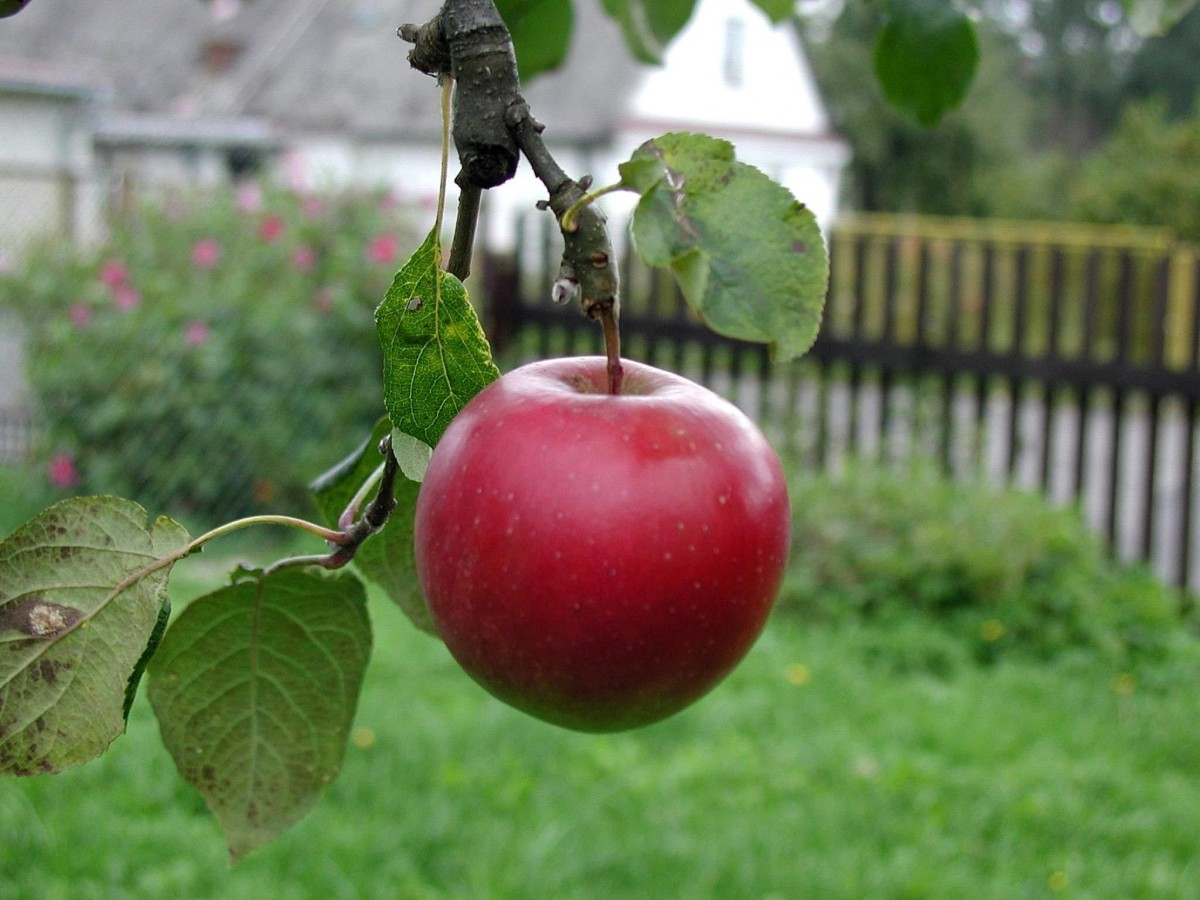

In [2]:
# We are able to open an image to take a look at it.
PIL.Image.open(str(images[0]))

In [3]:
# Define some hyperparameters
batch_size = 32
img_height = 180
img_width = 180

num_classes = 9
kernel_size = 3

In [4]:
# Use Keras to define the data and create the tensors for us
# Default functionality is to shuffle the data so no need to worry about that.
print("~~~Create Training Data~~~")
ds_train = tf.keras.utils.image_dataset_from_directory(
  main_directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print('')
print("~~~Create Testing Data~~~")
ds_test = tf.keras.utils.image_dataset_from_directory(
  main_directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

~~~Create Training Data~~~
Found 360 files belonging to 9 classes.
Using 288 files for training.

~~~Create Testing Data~~~
Found 360 files belonging to 9 classes.
Using 72 files for validation.


In [5]:
# Let us peek into the class names that we have extracted.
# This will match the directory name the files live in.
class_names = ds_train.class_names
print(class_names)

['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']


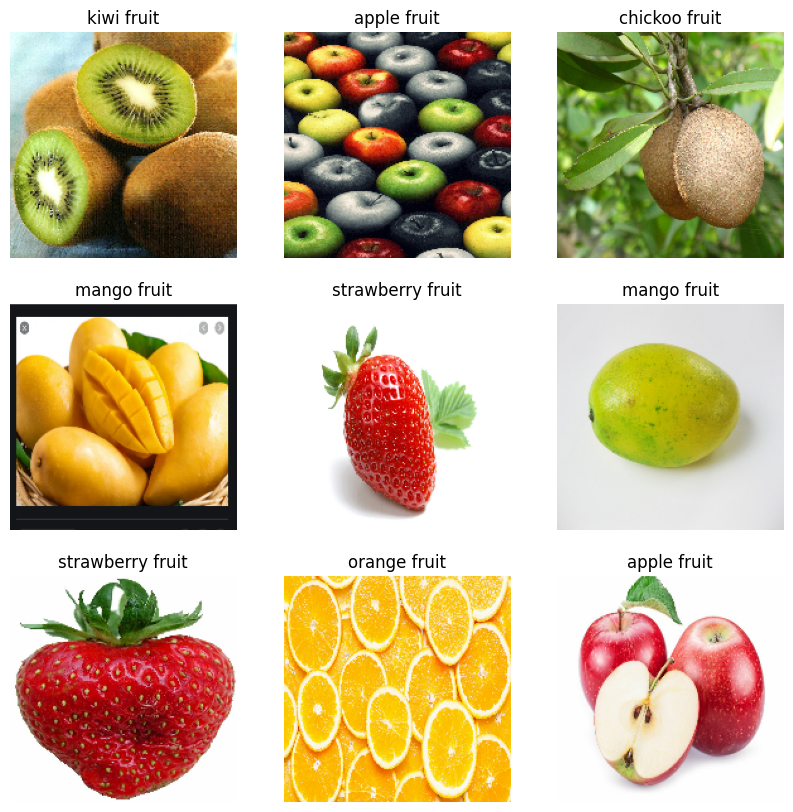

In [6]:
import matplotlib.pyplot as plt


# Here we plot an example image for each directory.
plt.figure(figsize=(10,10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
#Information about the shape of the tensor created. 
#These should match the hyper parameters defined above. 
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [8]:
#RGB has channel values of 255.
#We need to normalize the values to make it easier to compute.

normalization_layer = tf.keras.layers.Rescaling(1./255)

#See what happens with you follow this note
#Note: If you would like to scale pixel values to [-1,1] 
#      you can instead write tf.keras.layers.Rescaling(1./127.5, offset=-1)

#You can also add a manual resizing layer here instead of on import using
#    tf.keras.layers.Resizing layer

In [9]:
#Information about the first image and its normalized form.
ds_normalized = ds_train.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(ds_normalized))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Let us build the sequential model.
# First, rescalse the image.
# Second, pass the image through 3 Conv2d into MaxPooling2d blocks.
# Finish with a Flatten and Dense so the NN can process things
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(batch_size, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [12]:
#Compile the model with an adam optimizer.
#For some reason, everyone uses the adam optimizer. Needs more research.
#We implement a loss function called Sparse Categorical Cross Entropy.
#We do so because it does something at the boundaries of each category.
#This allows us to get the results we are looking for. More reasearch is needed.
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
#We train the model over 3 epochs.
#Adjusting hyper params and # of epochs will alter performance
model.fit(ds_train, validation_data=ds_test, epochs=3)

#After several runs, we get the following results:
#loss: 0.0515 - accuracy: 0.9965 - val_loss: 0.4283 - val_accuracy: 0.9028

#We have an accuracy on the training data of 99.65% which is nice.
#In practice, when put against the test data we have an accuracy of 90.28%

#In an enterprise setting, at a theoretical fruit sorting factory. 
#The accuracy would need to be improved.

#We can increase the model with more data directly from the production setting.
#We can increase the training time. 

Epoch 1/3
9/9 [==============================] - 17s 1s/step - loss: 2.1957 - accuracy: 0.1667 - val_loss: 2.0568 - val_accuracy: 0.2639
Epoch 2/3
9/9 [==============================] - 7s 808ms/step - loss: 1.8829 - accuracy: 0.3750 - val_loss: 1.6768 - val_accuracy: 0.3611
Epoch 3/3
9/9 [==============================] - 8s 861ms/step - loss: 1.4280 - accuracy: 0.5139 - val_loss: 1.4619 - val_accuracy: 0.4583


# Manual import method


In [14]:
#This is a more manual way of importing the data that can be useful in alternate settings.
#This is for either reference, and my practice.
ds_list = tf.data.Dataset.list_files(main_directory_glob, shuffle=False)
ds_list = ds_list.shuffle(len(images), reshuffle_each_iteration=False)
for file in ds_list.take(25):
    print(file.numpy())

b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_38.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_13.png'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_34.jpeg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_15.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_3.jpeg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_6.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_21.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_20.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_1.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_24.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_7.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_11.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_19.jpg'
b'/kaggle/input/fruits-dataset-images/images/apple fruit/Image_18.jpg'
b'/kaggl

In [15]:
#Class names.
class_names = np.array(sorted(imagesByCategory.keys()))
print(class_names)

['apple fruit' 'banana fruit' 'cherry fruit' 'chickoo fruit'
 'grapes fruit' 'kiwi fruit' 'mango fruit' 'orange fruit'
 'strawberry fruit']


In [16]:
#Manual split. Not using Keras. 
val_size = int(len(ds_list) * .2)
ds_train_man = ds_list.skip(val_size)
ds_test_man = ds_list.take(val_size)

print(tf.data.experimental.cardinality(ds_train_man).numpy())
print(tf.data.experimental.cardinality(ds_test_man).numpy())

288
72


In [17]:
#Define the functions that can be used to split the data manually. 
def get_label(file_path):
    breakdownURL = tf.strings.split(file_path, os.path.sep)
    one_hot = breakdownURL[-2] == class_names
    return tf.argmax(one_hot)

def decode_img(img):
    # Convert the the image to a tensor with dtype='uint8'
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [18]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
ds_train_man = ds_train_man.map(process_path, num_parallel_calls=AUTOTUNE)
ds_test_man = ds_test_man.map(process_path, num_parallel_calls=AUTOTUNE)

In [19]:
#The defined functions are used during the take call.
# Honesty, I need to read more into how the take function works.
# This is inorder to understand how the defined functions override defaults.
for image, label in ds_train_man.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  2


In [20]:
#Perfomance configurations
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

ds_train_man = configure_for_performance(ds_train_man)
ds_test_man = configure_for_performance(ds_test_man)

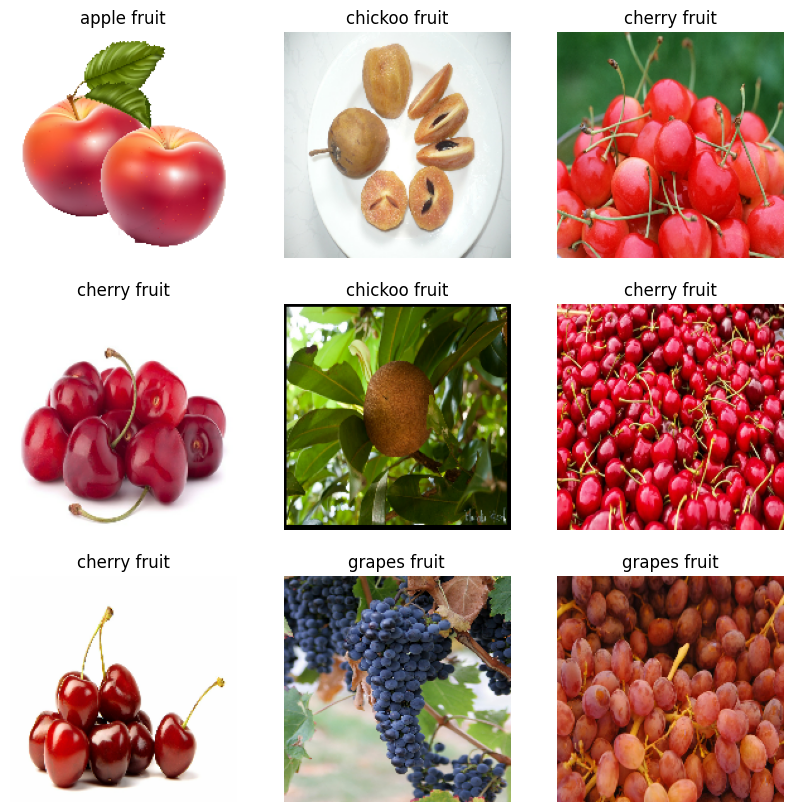

In [21]:
#Take a look at the data again.
image_batch, label_batch = next(iter(ds_train_man))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [22]:
# Running the model again here. 
model.fit(
  ds_train_man,
  validation_data=ds_test_man,
  epochs=3
)

#After several runs, we get the following results:
#loss: 0.0303 - accuracy: 0.9965 - val_loss: 0.3891 - val_accuracy: 0.9306

#We have an accuracy on the training data of 99.65% which is nice.
#In practice, when put against the test data we have an accuracy of 93.06%

#In an enterprise setting, at a theoretical fruit sorting factory. 
#The accuracy would need to be improved.

#We can increase the model with more data directly from the production setting.
#We can increase the training time. 

Epoch 1/3
9/9 [==============================] - 14s 1s/step - loss: 1.4189 - accuracy: 0.5174 - val_loss: 4.0106 - val_accuracy: 0.0139
Epoch 2/3
9/9 [==============================] - 7s 815ms/step - loss: 1.7872 - accuracy: 0.3542 - val_loss: 2.5125 - val_accuracy: 0.0139
Epoch 3/3
9/9 [==============================] - 7s 828ms/step - loss: 1.0799 - accuracy: 0.6632 - val_loss: 3.2103 - val_accuracy: 0.0139
